In [1]:
%load_ext autoreload
%autoreload 2


import os

os.chdir("..")

In [2]:
from sam import *
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from copy import deepcopy
from sam.data_formats import read_data
from sam.helpers import pad_c0

In [3]:
names = [
    ("2001 Liess-food, UV Cu/data.xlsx", "Food_1% + UV"),
    ("2019 Naeem-Esf, Pro, food/21_days.xlsx", "Food_1% + Prochloraz_100"),
    ("2019 Naeem-Esf, Pro, food/21_days.xlsx", "Food_1% + Prochloraz_32"),
    ("2024 Naeem-Esfe, °C, food/21_days.xlsx", "Food_1% + Temp_25"),
]

In [4]:
def pred_exp(
    path, exp, new=False, hormesis_index=None, param_d_norm=True, max_sys_stress=0.1
):
    settings = deepcopy(STANDARD_SAM_SETTING)
    settings.cancel_system_stress = new
    settings.param_d_norm = param_d_norm
    settings.max_system_stress = max_sys_stress

    data = read_data(f"data/{path}")

    val = data.additional_stress[exp]

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=settings,
        hormesis_index=hormesis_index,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=f"{data.meta.title} - {exp}",
    )

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    if new:
        lines = fig.axes[1].get_lines()
        only_tox = [line for line in lines if line.get_label() == "Tox"][0]
        only_tox.set_label("Original Tox")

        fig.axes[0].plot(
            main_fit.concentrations,
            main_fit.cleaned_survival,
            label="$\\text{Tox}$",
            color=color_cycle[0],
            linestyle="-",
        )
        fig.axes[1].plot(
            main_fit.concentrations,
            main_fit.cleaned_stress,
            label="$\\text{Tox}$",
            color=color_cycle[0],
            linestyle="-",
        )

        fig.axes[0].plot(
            main_fit.concentrations,
            main_fit.modified_control_surv,
            color=color_cycle[0],
            linestyle="dotted",
        )
        fig.axes[1].plot(
            main_fit.concentrations,
            main_fit.modified_control_stress,
            label="$\\text{Tox} + \\text{Sys}$",
            color=color_cycle[0],
            linestyle="dotted",
        )

        fig.axes[1].plot(
            main_fit.concentrations,
            main_fit.pred_system_stress,
            label="$\\text{Sys}$",
            color=color_cycle[3],
        )

        handles, labels = fig.axes[1].get_legend_handles_labels()
        order = [0, 3, 4, 5, 1, 2]
        fig.axes[-1].legend(
            [handles[idx] for idx in order],
            [labels[idx] for idx in order],
            bbox_to_anchor=(1, 1),
        )

    else:
        fig.axes[-1].legend(bbox_to_anchor=(1, 1))
    plt.show()

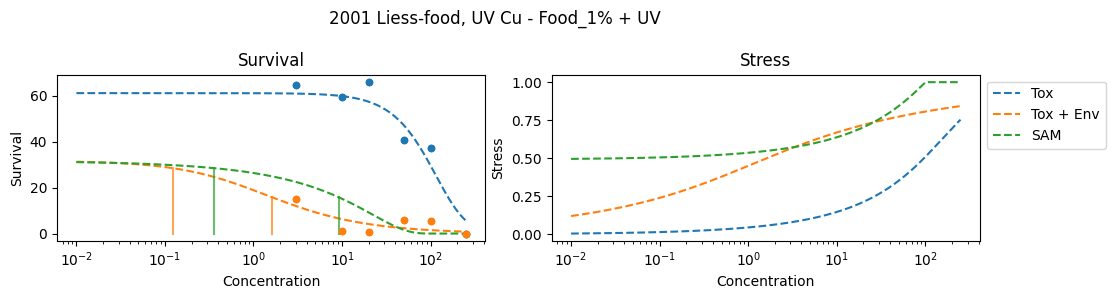

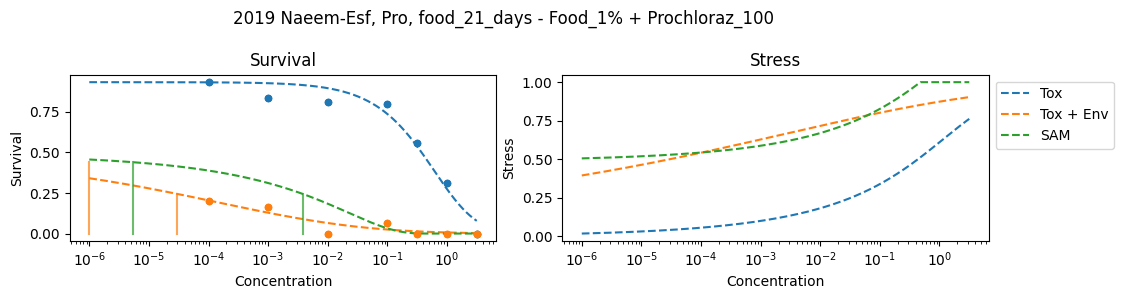

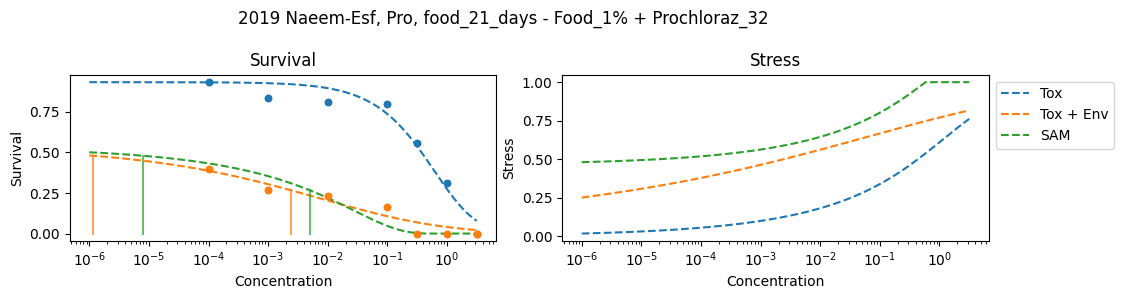

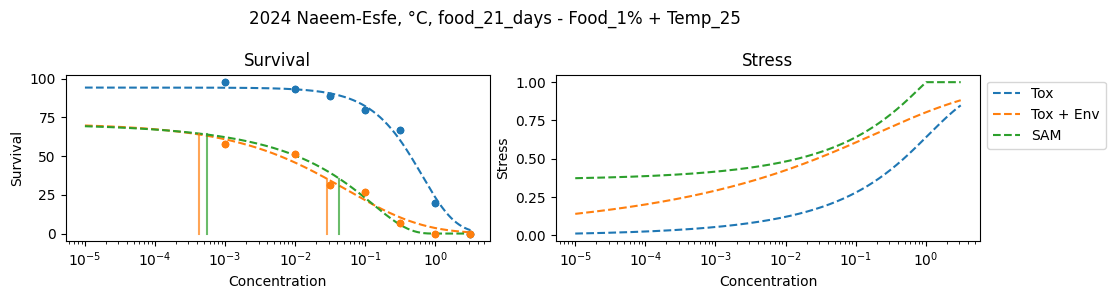

In [5]:
for name in names:
    pred_exp(*name, new=False, hormesis_index=None)

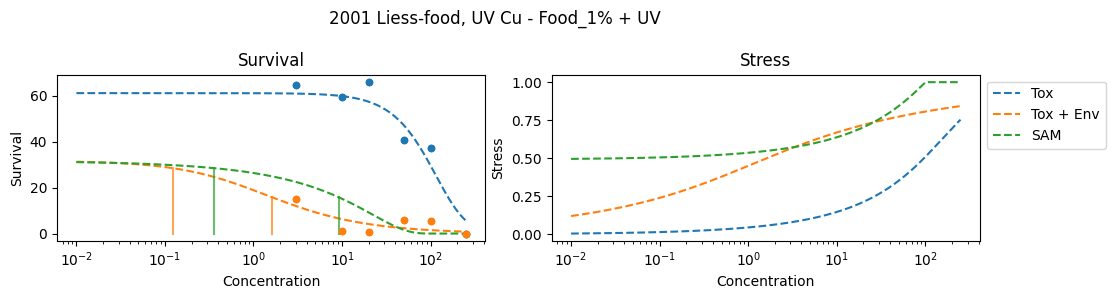

0.2911695425710433 0.1 0.1


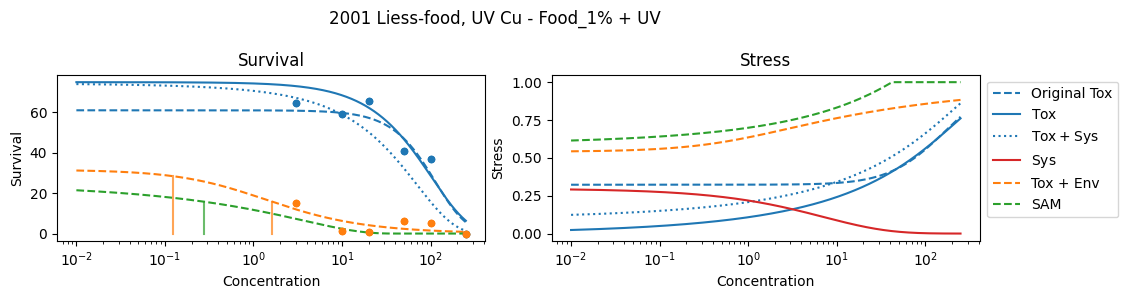

In [6]:
name = names[0]
pred_exp(*name, new=False, hormesis_index=None)
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.1, param_d_norm=False)

0.19706317589227906 0.2 0.19706317589227906


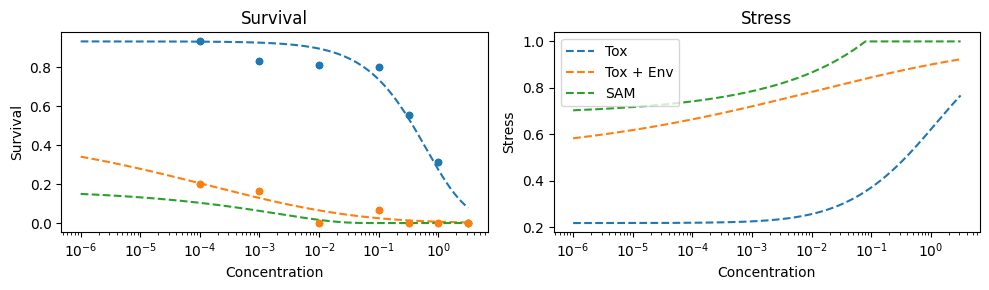

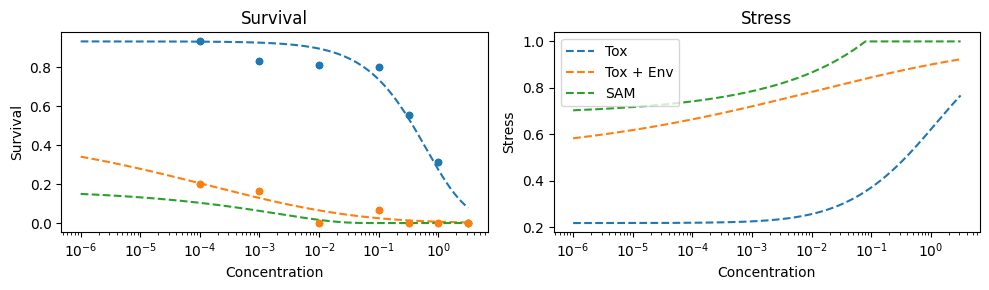

In [7]:
path, exp = names[1]
hormesis_index = 4

settings = deepcopy(STANDARD_SAM_SETTING)
settings.cancel_system_stress = True
settings.param_d_norm = False
settings.max_system_stress = 0.2

data = read_data(f"data/{path}")

val = data.additional_stress[exp]

main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
    data.main_series,
    val,
    data.meta,
    settings=settings,
    hormesis_index=hormesis_index,
)

lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
plot_sam_prediction(main_fit, stress_fit, sam_sur, sam_stress)

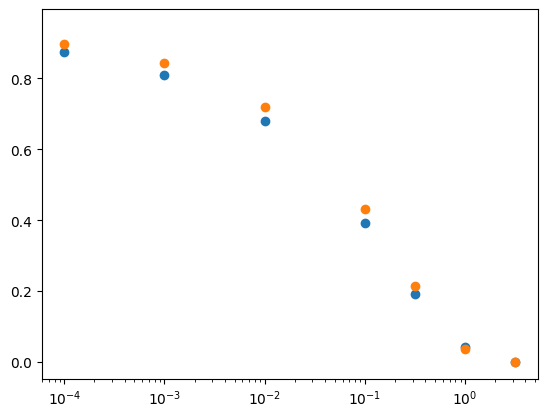

In [15]:
surv = main_fit.without_horm(main_fit.inputs.concentration)
stress = survival_to_stress(surv) + 0.2
mypoints = stress_to_survival(stress)
ser = DoseResponseSeries(
    [
        0,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.316,
        1,
        3.16,
    ],
    [0.933, 0.875, 0.81, 0.679, 0.393, 0.191, 0.042, 0],
    name="matthias",
)
plt.scatter(ser.concentration, ser.survival_rate)
plt.scatter(ser.concentration, mypoints)
plt.xscale("log")
plt.show()

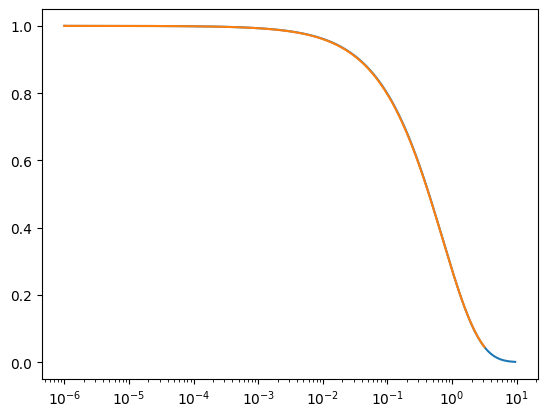

In [9]:
surv_indi = pd.read_csv("curve_points_surv.csv")
plt.plot(surv_indi.Concentration, surv_indi.Survival_Tox)
plt.plot(main_fit.concentrations, main_fit.cleaned_survival)
plt.xscale("log")
plt.show()

In [10]:
stress_indi = pd.read_csv("curve_points_stress.csv")

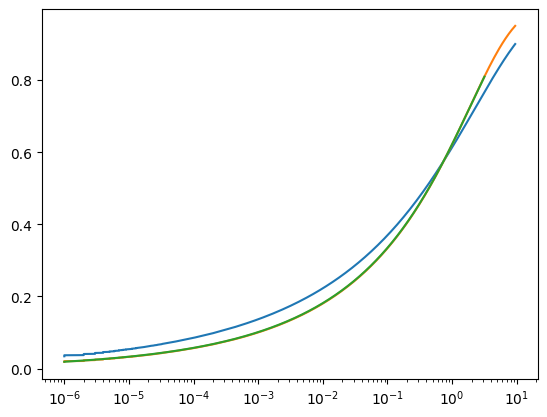

In [11]:
plt.plot(surv_indi.Concentration, stress_indi.Stress_Tox)
plt.plot(surv_indi.Concentration, survival_to_stress(surv_indi.Survival_Tox))
plt.plot(main_fit.concentrations, main_fit.cleaned_stress)
plt.xscale("log")
plt.show()

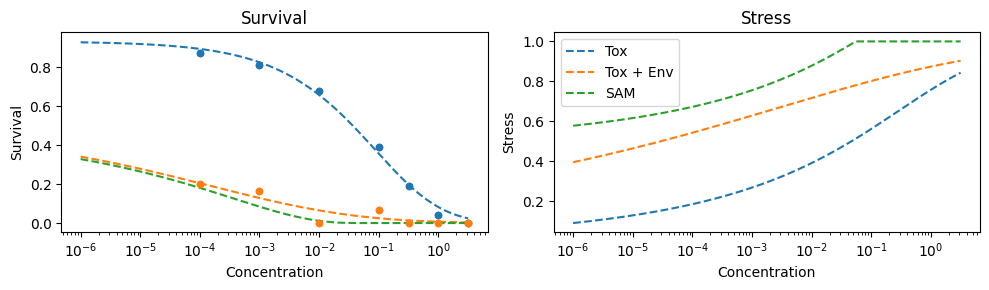

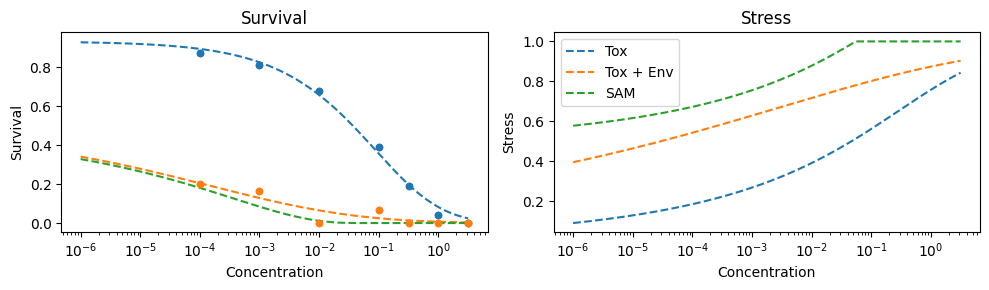

In [ ]:
settings = deepcopy(STANDARD_SAM_SETTING)
settings.cancel_system_stress = False
settings.param_d_norm = True
settings.max_system_stress = 0.2

ser = DoseResponseSeries(
    [
        0,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.316,
        1,
        3.16,
    ],
    [0.933, 0.875, 0.81, 0.679, 0.393, 0.191, 0.042, 0],
    name="matthias",
)
main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
    ser,
    val,
    data.meta,
    settings=settings,
    hormesis_index=hormesis_index,
)

lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
plot_sam_prediction(main_fit, stress_fit, sam_sur, sam_stress)

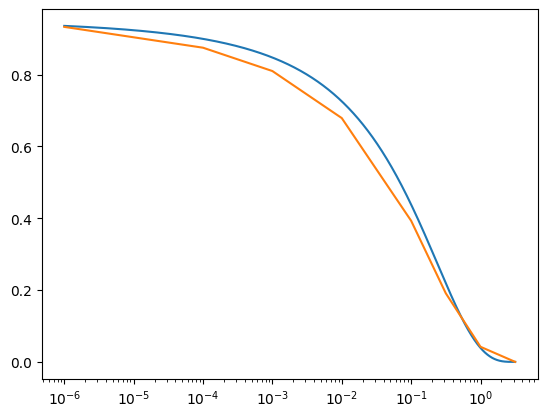

In [7]:
plt.plot(main_fit.concentrations, main_fit.modified_control_surv)
plt.plot(
    [
        main_fit.concentrations.min(),
        0.0001,
        0.001,
        0.01,
        0.1,
        0.316,
        1,
        3.16,
    ],
    [0.933, 0.875, 0.81, 0.679, 0.393, 0.191, 0.042, 0],
)
plt.xscale("log")

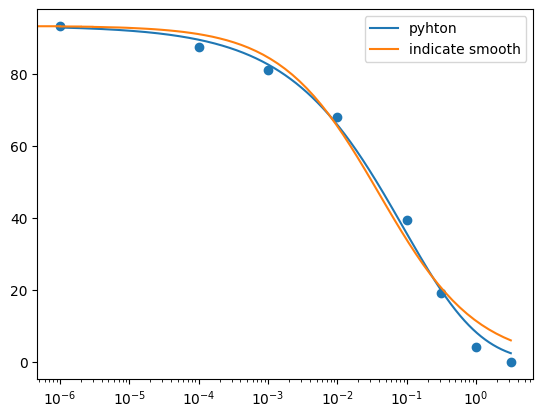

In [15]:
concs = [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.000001,
    0.000001,
    0.000001,
    0.000001,
    0.000002,
    0.000002,
    0.000003,
    0.000003,
    0.000004,
    0.000005,
    0.000007,
    0.000009,
    0.000011,
    0.000014,
    0.000018,
    0.000023,
    0.000029,
    0.000037,
    0.000047,
    0.00006,
    0.000076,
    0.000097,
    0.000123,
    0.000157,
    0.000199,
    0.000254,
    0.000323,
    0.000412,
    0.000525,
    0.000668,
    0.000851,
    0.001083,
    0.00138,
    0.001757,
    0.002238,
    0.00285,
    0.003629,
    0.004621,
    0.005885,
    0.007495,
    0.009545,
    0.012155,
    0.015479,
    0.019713,
    0.025104,
    0.03197,
    0.040714,
    0.051849,
    0.066029,
    0.084088,
    0.107086,
    0.136373,
    0.17367,
    0.221168,
    0.281656,
    0.358687,
    0.456785,
    0.581713,
    0.740808,
    0.943415,
    1.201433,
    1.530018,
    1.948468,
    2.481362,
    3.16,
]

surv = [
    93.2993,
    93.29921,
    93.29908,
    93.29894,
    93.29877,
    93.29858,
    93.29835,
    93.29809,
    93.29779,
    93.29744,
    93.29703,
    93.29656,
    93.29602,
    93.29539,
    93.29465,
    93.29381,
    93.29283,
    93.29169,
    93.29037,
    93.28885,
    93.28708,
    93.28503,
    93.28266,
    93.27991,
    93.27673,
    93.27304,
    93.26876,
    93.26381,
    93.25808,
    93.25143,
    93.24373,
    93.23482,
    93.22449,
    93.21253,
    93.19867,
    93.18262,
    93.16404,
    93.14251,
    93.11759,
    93.08872,
    93.05531,
    93.01662,
    92.97184,
    92.92001,
    92.86003,
    92.79064,
    92.71038,
    92.61756,
    92.51025,
    92.38623,
    92.24296,
    92.07753,
    91.88660,
    91.66638,
    91.41256,
    91.12023,
    90.78387,
    90.39726,
    89.95344,
    89.44465,
    88.86233,
    88.19707,
    87.43866,
    86.57612,
    85.59784,
    84.49170,
    83.24537,
    81.84659,
    80.28364,
    78.54585,
    76.62425,
    74.51225,
    72.20638,
    69.70713,
    67.01953,
    64.15378,
    61.12555,
    57.95604,
    54.67161,
    51.30314,
    47.88493,
    44.45340,
    41.04553,
    37.69729,
    34.44215,
    31.30982,
    28.32527,
    25.50814,
    22.87257,
    20.42725,
    18.17590,
    16.11779,
    14.24853,
    12.56077,
    11.04500,
    9.690201,
    8.484435,
    7.415398,
    6.470783,
    5.638598,
    4.907388,
]


smooth = [
    93.299515,
    93.299437,
    93.299347,
    93.299243,
    93.299122,
    93.298981,
    93.298818,
    93.298628,
    93.298409,
    93.298154,
    93.297859,
    93.297516,
    93.297118,
    93.296657,
    93.296122,
    93.295501,
    93.294781,
    93.293945,
    93.292976,
    93.291852,
    93.290547,
    93.289034,
    93.287279,
    93.285243,
    93.282881,
    93.280141,
    93.276962,
    93.273275,
    93.268998,
    93.264037,
    93.258282,
    93.251607,
    93.243865,
    93.234884,
    93.224468,
    93.212388,
    93.198377,
    93.182129,
    93.163287,
    93.141438,
    93.116104,
    93.086731,
    93.05268,
    93.013208,
    92.967459,
    92.914443,
    92.853015,
    92.781854,
    92.699439,
    92.604012,
    92.493555,
    92.365744,
    92.217914,
    92.04701,
    91.849538,
    91.621511,
    91.358394,
    91.055042,
    90.705642,
    90.30365,
    89.841746,
    89.311781,
    88.704754,
    88.010808,
    87.219249,
    86.318625,
    85.29685,
    84.141397,
    82.839584,
    81.378946,
    79.747719,
    77.935424,
    75.933554,
    73.736332,
    71.341505,
    68.751123,
    65.972215,
    63.017295,
    59.904601,
    56.657997,
    53.306485,
    49.88333,
    46.424826,
    42.968795,
    39.552953,
    36.21328,
    32.982549,
    29.889136,
    26.956193,
    24.201209,
    21.635968,
    19.266817,
    17.095205,
    15.118376,
    13.330154,
    11.721734,
    10.282432,
    9.000363,
    7.863008,
    6.857686,
    5.971915,
]


ser = DoseResponseSeries(
    [
        0,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.316,
        1,
        3.16,
    ],
    [0.933, 0.875, 0.81, 0.679, 0.393, 0.191, 0.042, 0],
    name="matthias",
)

main_fit = dose_response_fit(ser, DRF_Settings(max_survival=100))
plt.plot(main_fit.concentrations, main_fit.survival_curve * 100, label="pyhton")
plt.plot(concs, smooth, label="indicate smooth")
plt.scatter(
    [
        main_fit.concentrations.min(),
        0.0001,
        0.001,
        0.01,
        0.1,
        0.316,
        1,
        3.16,
    ],
    np.array([0.933, 0.875, 0.81, 0.679, 0.393, 0.191, 0.042, 0]) * 100,
)
plt.xscale("log")
plt.legend()
plt.show()

0.19706317589227906 0.2 0.19706317589227906


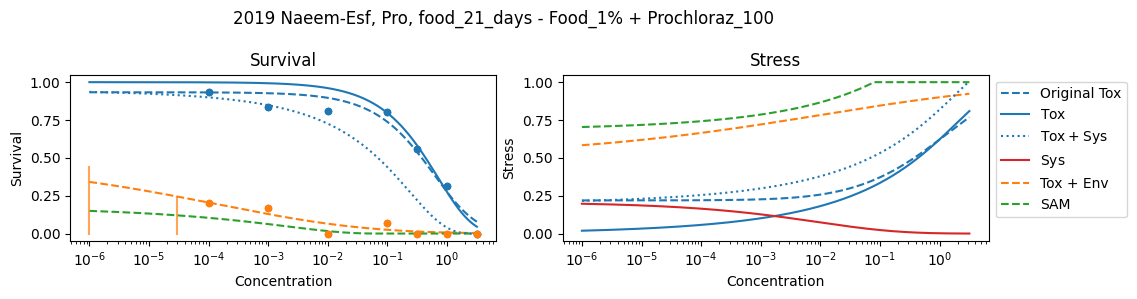

0.19706317589227906 0.2 0.19706317589227906


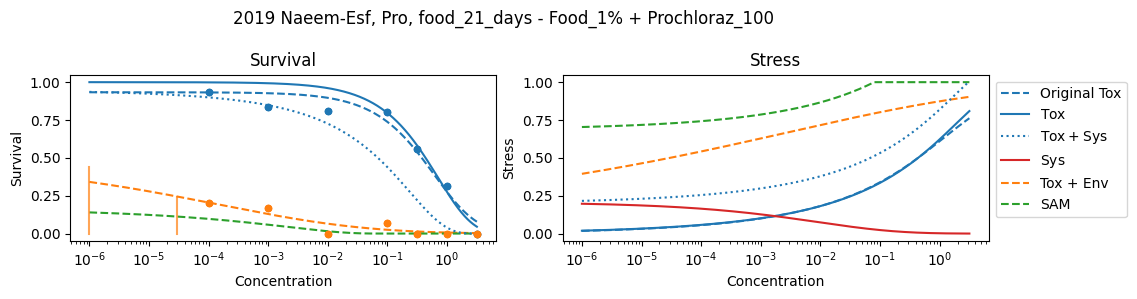

In [9]:
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.2, param_d_norm=False)
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.2, param_d_norm=True)

0.19706317589227906 0.1 0.1


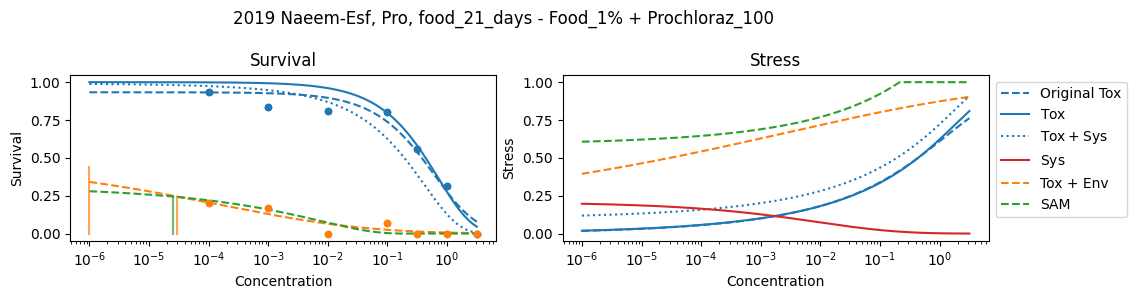

0.19706317589227906 0.2 0.19706317589227906


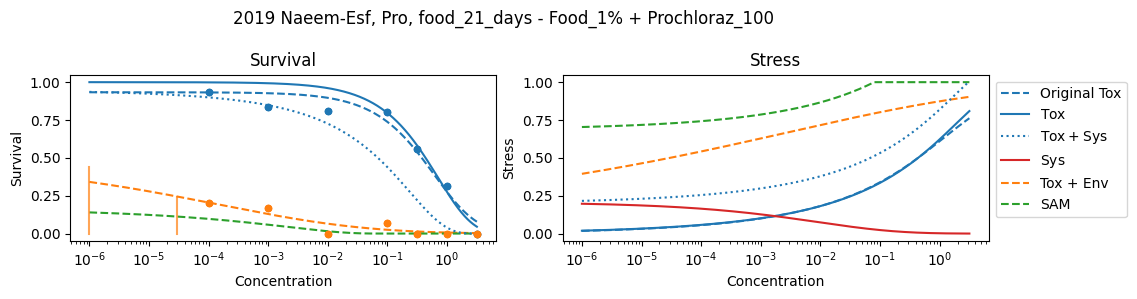

0.19706317589227906 0.3 0.19706317589227906


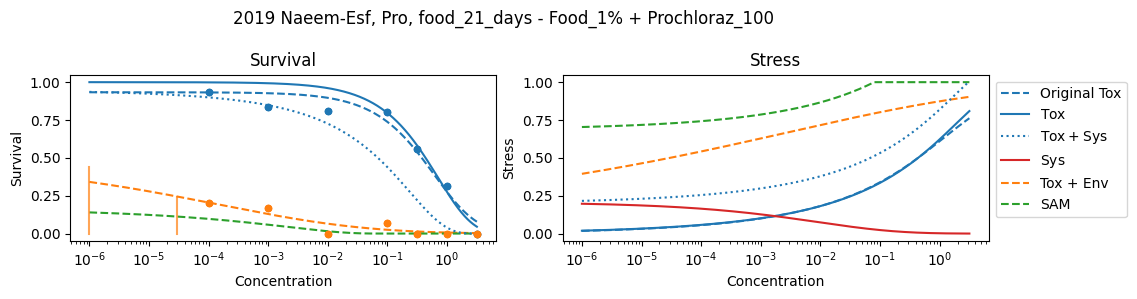

In [7]:
name = names[1]

pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.1)
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.2)
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.3)

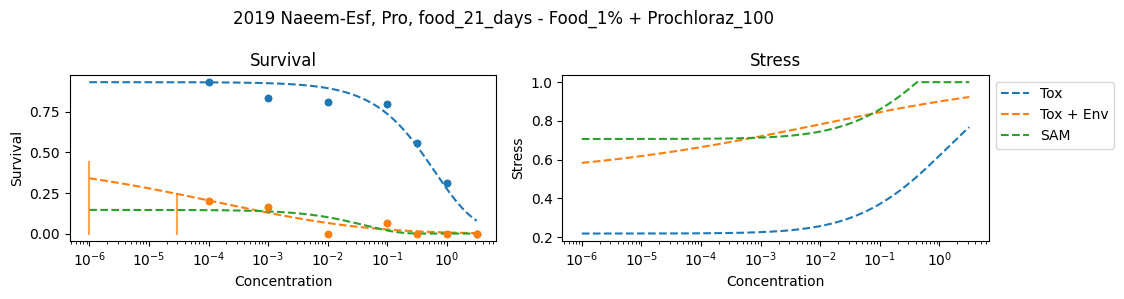

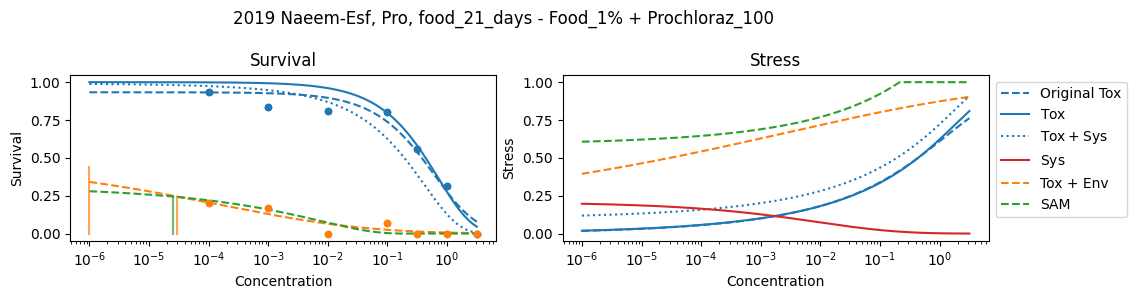

In [ ]:
pred_exp(*name, new=False, hormesis_index=None, param_d_norm=False)
pred_exp(*name, new=True, hormesis_index=4, max_sys_stress=0.3)

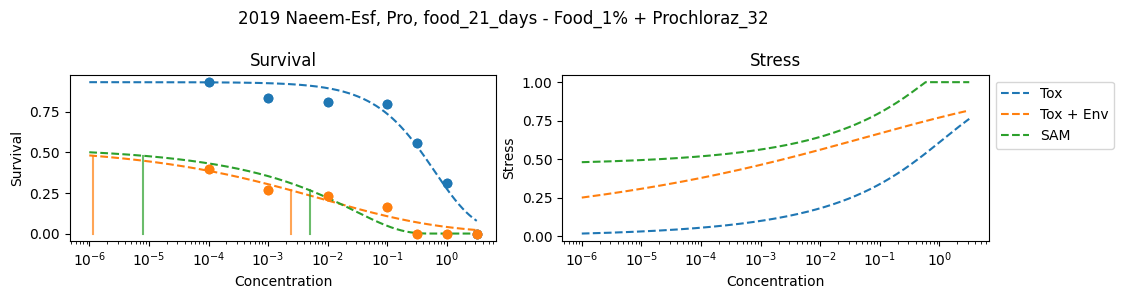

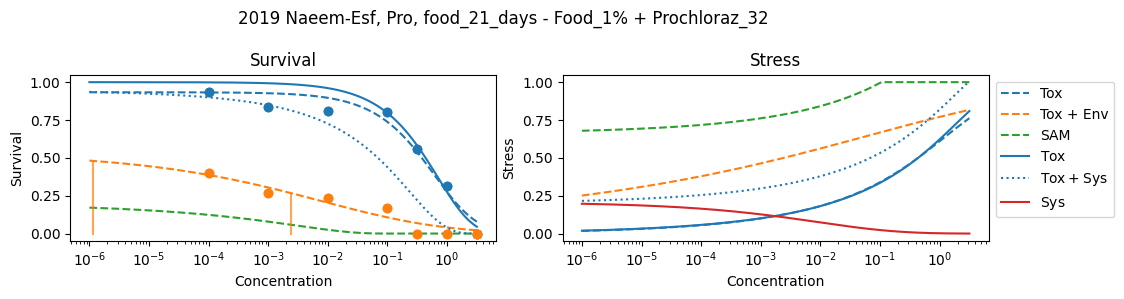

In [37]:
name = names[2]
pred_exp(*name, new=False, hormesis_index=None)
pred_exp(*name, new=True, hormesis_index=4)

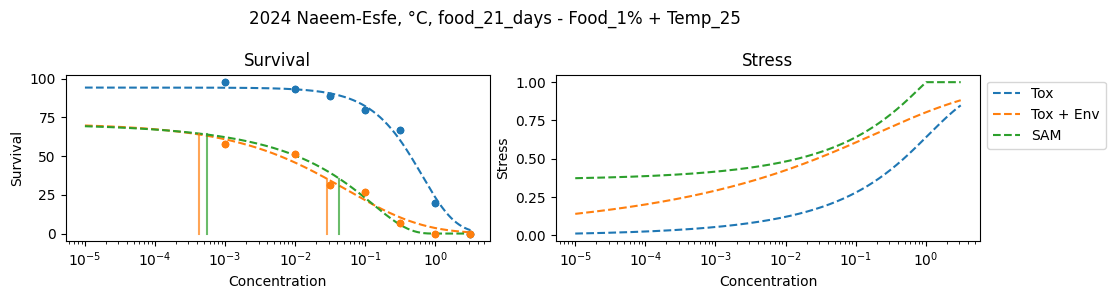

/home/felix/Desktop/sam/src/sam/stress_addition_model.py:164: UserWarning: could not find hormesis index, detecting it to be 2
  warn(f"could not find hormesis index, detecting it to be {hormesis_index}")


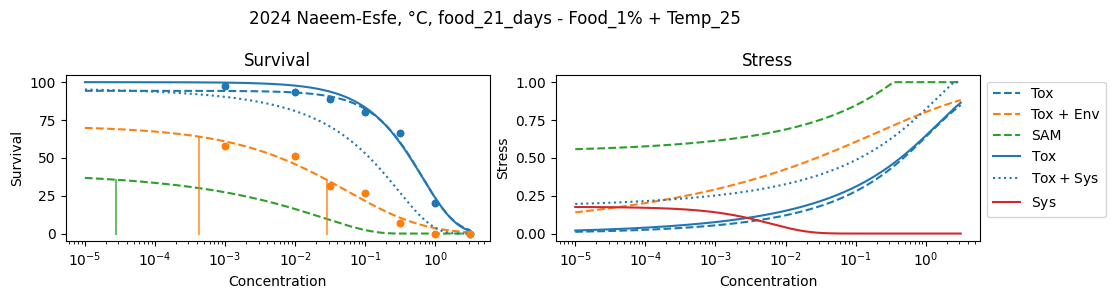

In [ ]:
name = names[3]
pred_exp(*name, new=False, hormesis_index=None)
pred_exp(*name, new=True, hormesis_index=None)